In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd

from PSGpy.utils import read_out

In [2]:
lyo_path = '/home/buriola/OD4Mars/NO_BACKUP/data/lyo/'
ranges = np.arange(90, 3050, 40)

In [3]:
gas = 'CO2' #gas to inpect
ff = 2315.20 #frequency to inpsect

In [4]:
def find_nearest(array, value):
    aa = array[array < value]
    val = aa[np.argmax(aa)]
    return val

In [5]:
freq = find_nearest(ranges, ff)
freqs = np.arange(freq-0.005, freq+40-0.005, 1e-4)+1e-4
low_freq = np.arange(freq, freq+40,1e-2)

In [6]:
tab = read_out(f'{lyo_path}{gas}/lyo_{gas}_{0}_freq{freq}_{freq+40}.txt')
tab = tab[:400000]

In [7]:
hh = tab.columns[1:].to_numpy(dtype='float64')
paths = np.diff(hh)
od_hr = tab.iloc[:,:-1].copy()

In [8]:
od_hr.iloc[:,1:]= tab.iloc[:,1:-1]*paths
od_hr = od_hr.iloc[::-1].reset_index(drop=True)

In [9]:
f_hr = od_hr.freq.to_numpy()
ods = od_hr.drop(columns = 'freq').to_numpy().T

In [10]:
tr = np.exp(-ods)

In [11]:
from scipy.stats import binned_statistic
sec_binned,bin_edges,binnumber = binned_statistic(x=f_hr,values=tr,statistic='mean',bins=4000)

In [12]:
sec_binned = np.clip(sec_binned, 1e-300, 1.0)
od_bin = -np.log(sec_binned)

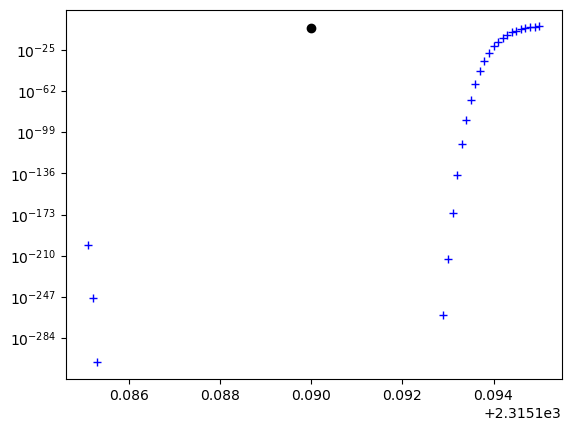

In [13]:
ff_tp = f_hr[binnumber==2520]
ods_tp = ods[37,binnumber==2520]
plt.plot(ff_tp, np.exp(-ods_tp.T), 'b+')
plt.plot(np.ones((1))*2315.19, np.exp(-od_bin[37,np.round(low_freq,2)==2315.19]), 'ko')
plt.yscale('log')
plt.show()

In [14]:
np.exp(-od_bin[37,np.round(low_freq,2)==2315.19])

array([2.20324944e-06])

In [15]:
np.exp(-ods[37,binnumber==2520]).mean()


np.float64(2.2032494381249e-06)

In [13]:
def OD_compute(data):
    altitude = data.columns[1:].to_numpy(dtype='float64')
    paths = np.diff(altitude)
    df_out = data.iloc[:,:-1].copy()
    df_out.iloc[:,1:] = data.iloc[:,1:-1]*paths
    df_out = df_out.iloc[::-1].reset_index(drop=True)
    return df_out

In [14]:
from scipy.stats import binned_statistic
def OD_binning(high_res, n_bins):
    #Get the high frequency and optical depth values
    f_high = high_res.freq.to_numpy()
    ods = high_res.drop(columns = 'freq').to_numpy().T
    #Compute transmittance and cumulative transmittance
    trn = np.exp(-ods)
    #cum_trn = np.cumprod(trn[::-1,:], axis=0)[::-1,:]
    binned,_,_ = binned_statistic(x=f_high,values=trn,statistic='mean',bins=n_bins)
    #sec_binned,_,_ = binned_statistic(x=f_high,values=ods,statistic='mean',bins=n_bins)
    
    binned = np.clip(binned, 1e-300, 1.0)
    od_bin = -np.log(binned)
    #mask = (binned[:-1] != 0) & (binned[1:] != 0)
    #np.divide(binned[:-1], binned[1:], out=od_bin[:-1], where=mask)
    #np.log(od_bin[:-1], out=od_bin[:-1], where=mask)
    #od_bin[:-1] = -od_bin[:-1]  # Convert transmittance to optical depth
    #od_bin[-1] = -np.log(binned[-1]) 

    return od_bin.T

In [16]:
DTs = np.arange(-60, 70, 10)
list_of_od = []
list_of_odb = []
for DT in DTs:
    tab = read_out(f'{lyo_path}{gas}/lyo_{gas}_{DT}_freq{freq}_{freq+40}.txt')
    tab = tab[:400000]
    tab_od = OD_compute(tab)
    list_of_od.append(tab_od.iloc[:,1:])
    tab_bin = OD_binning(tab_od,4000)
    list_of_odb.append(tab_bin)

In [17]:
tab = read_out(f'{lyo_path}{gas}/lyo_{gas}_{0}_freq{freq}_{freq+40}.txt')
hh = tab.columns[1:-1].to_numpy(dtype=float)

In [18]:
ODS = np.stack(list_of_od, axis = -1)
ODS_BIN = np.stack(list_of_odb, axis = -1)

xrODS = xr.DataArray(data = ODS, dims=['freq', 'altitude', 'DeltaT'], coords=dict(
                    freq = freqs,
                    altitude = hh,
                    DeltaT = DTs
                ))

xrODS_BIN = xr.DataArray(data = ODS_BIN, dims=['freq', 'altitude', 'DeltaT'], coords=dict(
                    freq = low_freq,
                    altitude = hh,
                    DeltaT = DTs
                ))

In [23]:
mask0 = xrODS_BIN.max(dim='DeltaT') < 1e-8
xrODS_BIN = xr.where(mask0, 0, xrODS_BIN)
maskMAX = xrODS_BIN <= 690.7
xrODS_BIN = xrODS_BIN.where(maskMAX, drop=False)

In [79]:
np.exp(-tttp).mean()

<xarray.DataArray ()> Size: 8B
array(5.84488399e-52)
Coordinates:
    altitude  float64 8B 38.13
    DeltaT    int64 8B 0

In [77]:
np.exp(-tttpb)

<xarray.DataArray ()> Size: 8B
array(5.84488399e-52)
Coordinates:
    freq      float64 8B 2.315e+03
    altitude  float64 8B 38.13
    DeltaT    int64 8B 0

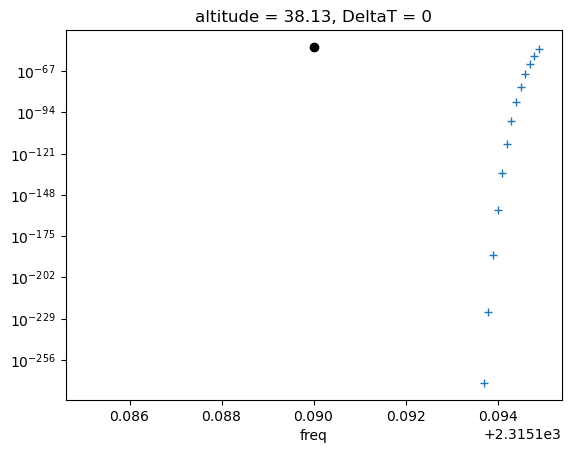

In [67]:
np.exp(-tttp).plot(marker = '+', linestyle = '')
plt.plot([2315.19], np.exp(-tttpb), 'ko')
plt.yscale('log')

In [87]:
toplot_od = xrODS.sel(altitude=38, method='nearest').sel(freq=slice(2315.1851,2315.1951))
toplot_odb= xrODS_BIN.sel(altitude=38, method='nearest').sel(freq=slice(2315.1851,2315.1951))

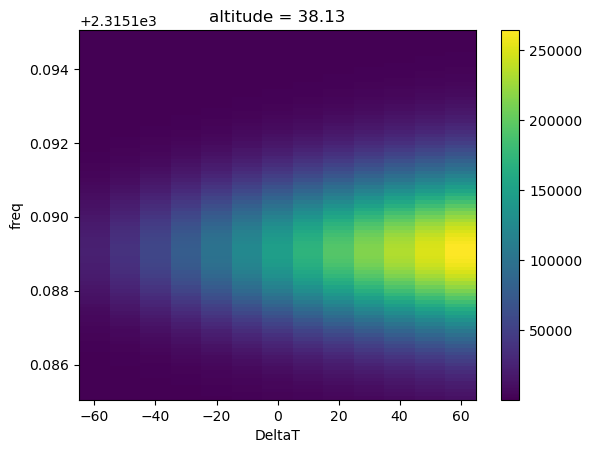

In [88]:
toplot_od.plot()
plt.show()

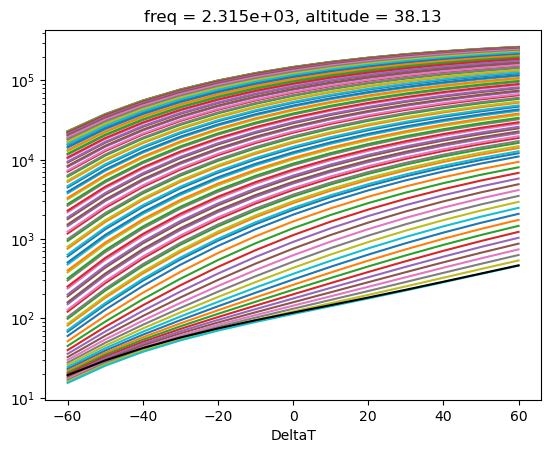

In [89]:
fig,ax = plt.subplots()
toplot_od.plot.line(x='DeltaT', hue = 'freq', add_legend=False, ax=ax)
toplot_odb.plot.line(x='DeltaT', color = 'k', ax = ax, add_legend=False)
plt.yscale('log')
plt.show()


In [14]:
boh = -np.log(np.clip(np.exp(-toplot_od).mean(dim='freq'), 1e-300,1))


In [15]:
np.exp(-boh)

<xarray.DataArray (DeltaT: 13)> Size: 104B
array([6.97894499e-052, 1.46092073e-078, 9.83493392e-111, 1.09312322e-147,
       5.57316283e-189, 1.11883941e-234, 1.24188657e-285, 1.00000000e-300,
       1.00000000e-300, 1.00000000e-300, 1.00000000e-300, 1.00000000e-300,
       1.00000000e-300])
Coordinates:
    altitude  float64 8B 30.57
  * DeltaT    (DeltaT) int64 104B -60 -50 -40 -30 -20 -10 0 10 20 30 40 50 60

In [16]:
np.exp(-toplot_odb)

<xarray.DataArray (freq: 1, DeltaT: 13)> Size: 104B
array([[5.38356780e-050, 1.44767865e-075, 2.70225255e-106,
        2.18022574e-141, 3.04392121e-180, 1.05624531e-222,
        3.00933712e-269, 1.00000000e-300, 1.00000000e-300,
        1.00000000e-300, 1.00000000e-300, 1.00000000e-300,
        1.00000000e-300]])
Coordinates:
  * freq      (freq) float64 8B 2.315e+03
    altitude  float64 8B 30.57
  * DeltaT    (DeltaT) int64 104B -60 -50 -40 -30 -20 -10 0 10 20 30 40 50 60

In [60]:
np.exp(-650)

np.float64(5.111951948651156e-283)

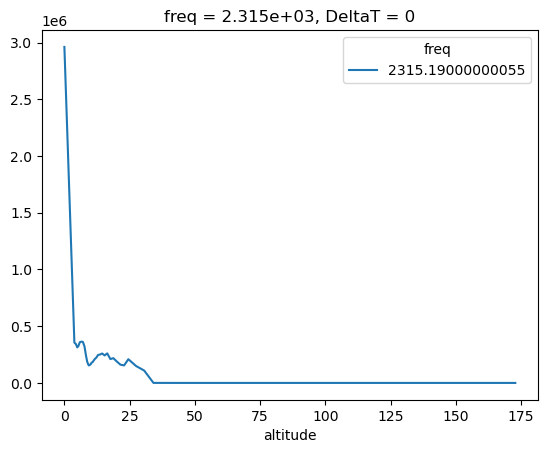

In [37]:
toplot_odb= xrODS_BIN.sel(DeltaT=0, method='nearest').sel(freq=slice(2315.1851,2315.1950))
toplot_odb.plot.line(x='altitude')
plt.show()